In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [28]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [29]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

(<AxesSubplot:xlabel='Date'>,)

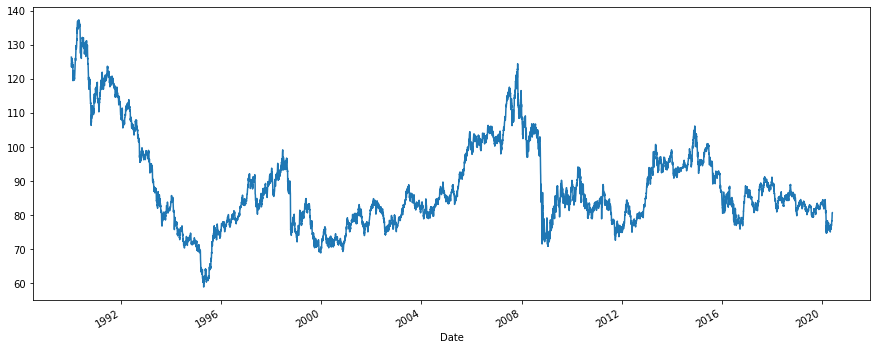

In [30]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(15,6)),

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Long term pattern is returns are slowly decreasing. short -term poattern is that pair will rise as it has reached downside support level. 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [31]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_noise, cad_jpy_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [32]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
#new_df = pd.DataFrame(cad_jpy_df["Date"], cad_jpy_df["Price"], ["cad_jpy_noise"], ["cad_jpy_trend"])
new_df = cad_jpy_df.drop(columns=['Open', 'High','Low'])
new_df["Noise"] = cad_jpy_noise
new_df["Trend"] = cad_jpy_trend
new_df

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037
...,...,...,...
2020-05-29,78.29,-0.503961,78.793961
2020-06-01,79.27,0.218939,79.051061
2020-06-02,80.40,1.088117,79.311883


<AxesSubplot:xlabel='Date'>

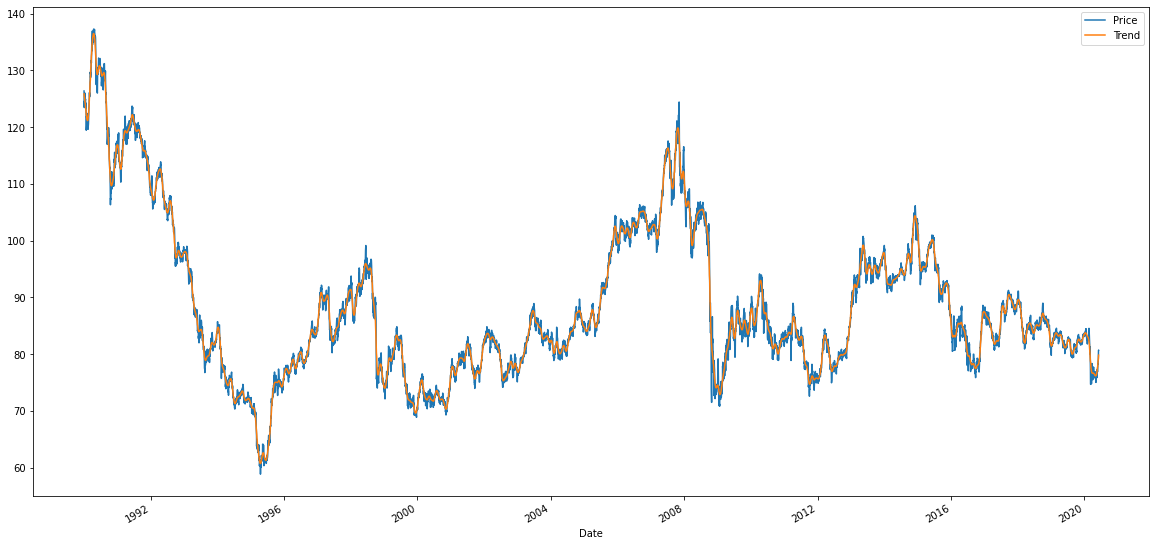

In [33]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
Trend_df = new_df.drop(columns=['Noise'])
lines = Trend_df.plot.line(figsize=(20,10))
lines

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Long term pattern is returns are slowly decreasing. short -term poattern is that pair will rise as it has reached downside support level. 

array([<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>],
      dtype=object)

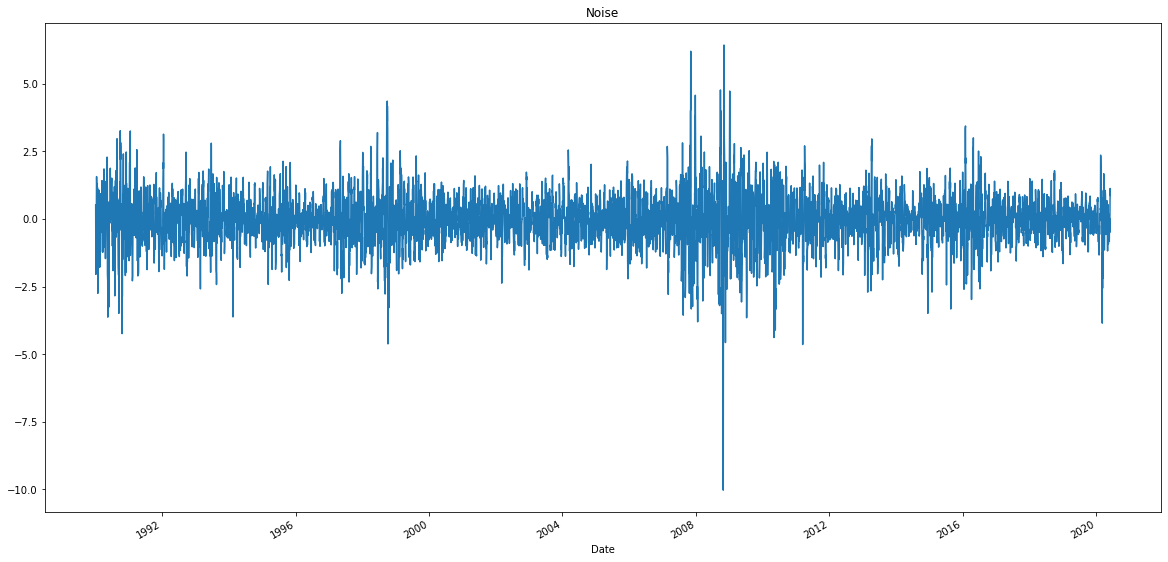

In [34]:
# Plot the Settle Noise
new_df.Noise.plot(figsize=(20,10), subplots=True, title={'Noise':'center'}, xlabel='Date')

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [35]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head()

,Price
Date,
1990-01-03,-0.846720
1990-01-04,-1.468476
1990-01-05,0.874777
1990-01-08,-0.216798
1990-01-09,0.667901


In [36]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [37]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sat, 29 Jan 2022   AIC                          19513.955
Time:                        12:16:45   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1704           +0.0000j           42.1704            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

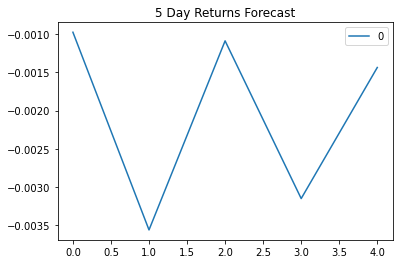

In [38]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** In statistics, the p-value is the probability of obtaining results at least as extreme as the observed results of a statistical hypothesis test, assuming that the null hypothesis is correct. The p-value is used as an alternative to rejection points to provide the smallest level of significance at which the null hypothesis would be rejected. A smaller p-value means that there is stronger evidence in favor of the alternative hypothesis.

P-value suggests that 2nd & 4th lag is much more significant than 1 st & 2nd lags. if we take 1 st and 2nd lag we will have to reject the null hypothesis   

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

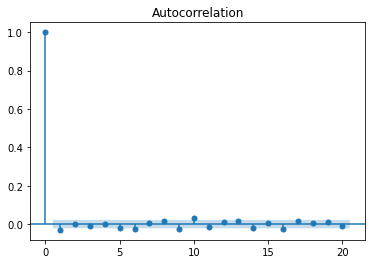

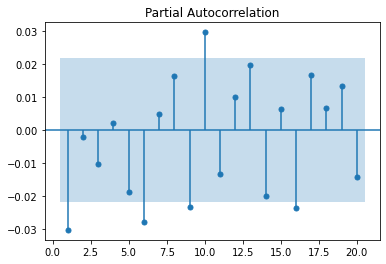

In [39]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(returns, lags=20);
plot_pacf(returns, zero=False, lags=20);

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
#from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(returns["Price"], order=(2, 1, 1))

# Fit the model
results1 = model.fit()

In [40]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7927
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9756.317
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sat, 29 Jan 2022   AIC                          19522.634
Time:                        12:17:00   BIC                          19557.524
Sample:                             1   HQIC                         19534.581
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.946e-06   5.94e-06      0.496      0.620    -8.7e-06    1.46e-05
ar.L1.D.Price    -0.0306      0.011     -2.722      0.006      -0.053      -0.009
ar.L2.D.Price    -0.0022      0.011     -0.196      0.845      -0.024       0.020
ma.L1.D.Price    -0.9995      0.001  -1083.137      0.000      -1.001      -0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.9407          -20.1413j           21.3037           -0.3028
AR.2           -6.9407          +20.1413j           21.3037            0.3028
MA.1            1.0005           +0.0000j            1.0005            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Price Forecast'}>

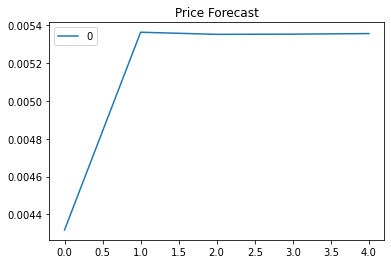

In [41]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results1.forecast(steps=5)[0]).plot(title="Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** Our forecast model shows that in near term Japnese Yen will rise in the near term. So we will issue a buy rating. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [42]:
import arch as arch

In [43]:
# Estimate a GARCH model:
from arch import arch_model
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(disp="off")

In [44]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sat, Jan 29 2022   Df Residuals:                     7928
Time:                        12:17:02   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [45]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [46]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2020-06-04', horizon=forecast_horizon)
forecasts

In [47]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [48]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:>

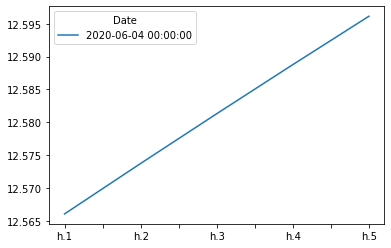

In [49]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:**  As we know Volatility can affect prices due to high risk it brings. So as per our forecast volatility over the next 5 Days will rise, which will make markets riskier. 

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Yes based on our time series analysis we will buy the yen. 

2. Is the risk of the yen expected to increase or decrease?
    * As per our forcast due to rise in volatility, risk of yen will increase.  

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * yes, based on our model, we would feel confident in buying this pair. As return & risk will both increase over next few days.  